In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import os
import requests
from tqdm import tqdm
import seaborn as sns
'''
# Function to download large files with progress bar
def download_file(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return
    
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    
    with open(filename, 'wb') as file, tqdm(
            desc=filename,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
        for data in response.iter_content(block_size):
            size = file.write(data)
            bar.update(size)

# Download datasets
download_file('https://cernbox.cern.ch/s/cDOFb5myDHGqRfc', 'Run355456_Dataset.npy')
download_file('https://cernbox.cern.ch/s/n8NvyK2ldUPUxa9', 'Run357479_Dataset.npy')

print("Dataset download complete (or files already exist).")
'''

D:\ml\ml4sci\ml4sci\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


'\n# Function to download large files with progress bar\ndef download_file(url, filename):\n    if os.path.exists(filename):\n        print(f"{filename} already exists, skipping download.")\n        return\n\n    response = requests.get(url, stream=True)\n    total_size = int(response.headers.get(\'content-length\', 0))\n    block_size = 1024\n\n    with open(filename, \'wb\') as file, tqdm(\n            desc=filename,\n            total=total_size,\n            unit=\'iB\',\n            unit_scale=True,\n            unit_divisor=1024,\n        ) as bar:\n        for data in response.iter_content(block_size):\n            size = file.write(data)\n            bar.update(size)\n\n# Download datasets\ndownload_file(\'https://cernbox.cern.ch/s/cDOFb5myDHGqRfc\', \'Run355456_Dataset.npy\')\ndownload_file(\'https://cernbox.cern.ch/s/n8NvyK2ldUPUxa9\', \'Run357479_Dataset.npy\')\n\nprint("Dataset download complete (or files already exist).")\n'

Dataset 1 shape: (10000, 64, 72)
Dataset 2 shape: (10000, 64, 72)


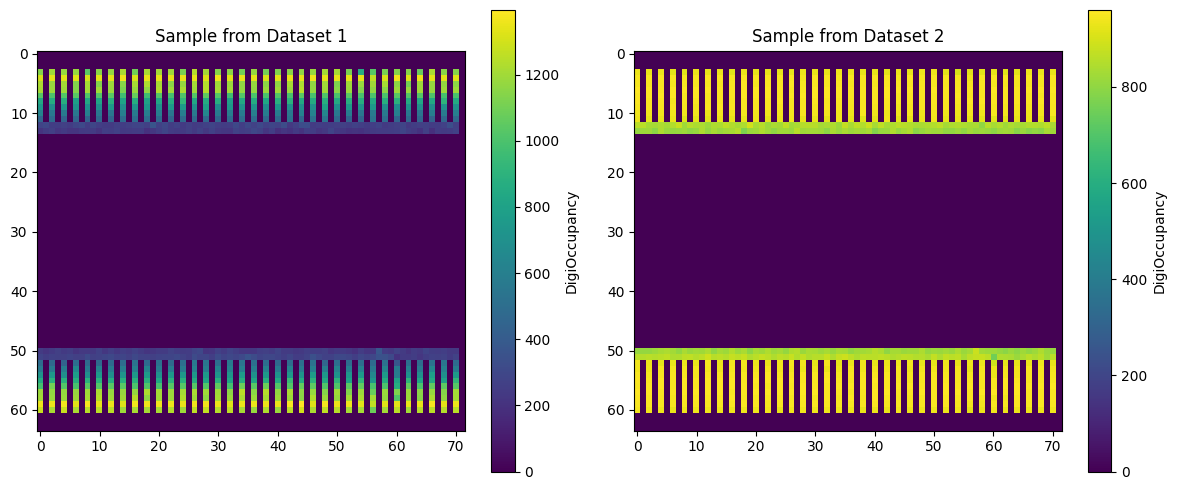

Dataset 1 - Min: 0.0, Max: 1564.944737802157, Mean: 157.1423, Std: 364.3050
Dataset 2 - Min: 0.0, Max: 1091.9733311864536, Mean: 181.0826, Std: 362.5289
Zero values percentage in Dataset 1: 79.77%
Zero values percentage in Dataset 2: 79.77%


In [5]:
# Load datasets
dataset_1 = np.load('Run355456_Dataset_jqkne.npy')
dataset_2 = np.load('Run357479_Dataset_iodic.npy')

print(f"Dataset 1 shape: {dataset_1.shape}")
print(f"Dataset 2 shape: {dataset_2.shape}")

# Let's visualize some samples from each dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(dataset_1[0], cmap='viridis')
plt.title('Sample from Dataset 1')
plt.colorbar(label='DigiOccupancy')

plt.subplot(1, 2, 2)
plt.imshow(dataset_2[0], cmap='viridis')
plt.title('Sample from Dataset 2')
plt.colorbar(label='DigiOccupancy')

plt.tight_layout()
plt.show()

# Basic statistics
print(f"Dataset 1 - Min: {dataset_1.min()}, Max: {dataset_1.max()}, Mean: {dataset_1.mean():.4f}, Std: {dataset_1.std():.4f}")
print(f"Dataset 2 - Min: {dataset_2.min()}, Max: {dataset_2.max()}, Mean: {dataset_2.mean():.4f}, Std: {dataset_2.std():.4f}")

# Check for zero values
zero_percentage_1 = (dataset_1 == 0).sum() / dataset_1.size * 100
zero_percentage_2 = (dataset_2 == 0).sum() / dataset_2.size * 100
print(f"Zero values percentage in Dataset 1: {zero_percentage_1:.2f}%")
print(f"Zero values percentage in Dataset 2: {zero_percentage_2:.2f}%")

In [6]:
# Create labels for both datasets
labels_1 = np.zeros(dataset_1.shape[0])
labels_2 = np.ones(dataset_2.shape[0])

# Combine datasets and labels
X = np.vstack([dataset_1, dataset_2])
y = np.concatenate([labels_1, labels_2])

# Reshape data for CNN-like input
X = X.reshape(-1, 64, 72, 1)  # (samples, height, width, channels)

# Normalize data
X_min = X.min()
X_max = X.max()
X_normalized = (X - X_min) / (X_max - X_min)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (16000, 64, 72, 1), (16000,)
Testing set: (4000, 64, 72, 1), (4000,)


In [11]:
def create_moe_vit_classifier():
    # Hyperparameters
    input_shape = (64, 72, 1)
    patch_size = 8
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 64
    transformer_layers = 4
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]
    mlp_head_units = [256, 128]
    num_experts = 4
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Patch extraction
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=(patch_size, patch_size),
        strides=(patch_size, patch_size),
        padding="valid",
    )(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)
    
    # Patch encoding
    patch_positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(patch_positions)
    encoded_patches = patches + position_embedding
    
    # Function to create a single expert MLP
    def create_expert():
        expert_input = layers.Input(shape=(projection_dim,))
        x = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(expert_input)
        x = layers.Dense(transformer_units[1])(x)
        model = keras.Model(expert_input, x)
        return model
    
    # Transformer blocks with MoE
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Mixture of Experts layer
        # Create experts
        experts = [create_expert() for _ in range(num_experts)]
        
        # Router
        router = layers.Dense(num_experts, activation="softmax")
        
        # Apply MoE
        batch_size = tf.shape(x3)[0]
        sequence_length = tf.shape(x3)[1]
        x3_flat = tf.reshape(x3, [-1, projection_dim])
        
        # Get routing weights
        routing_weights = router(x3_flat)
        
        # Initialize expert outputs
        expert_outputs = []
        for expert in experts:
            expert_out = expert(x3_flat)
            expert_outputs.append(expert_out)
        
        # Stack expert outputs
        stacked_experts = tf.stack(expert_outputs, axis=1)  # [batch*seq, num_experts, dim]
        
        # Weight outputs by router probabilities
        routing_weights = tf.expand_dims(routing_weights, axis=-1)  # [batch*seq, num_experts, 1]
        weighted_output = tf.reduce_sum(stacked_experts * routing_weights, axis=1)  # [batch*seq, dim]
        
        # Reshape back to original shape
        moe_output = tf.reshape(weighted_output, [batch_size, sequence_length, projection_dim])
        
        # Skip connection 2
        encoded_patches = layers.Add()([moe_output, x2])
    
    # Final layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
    # Global average pooling
    representation = layers.GlobalAveragePooling1D()(representation)
    
    # MLP head
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    
    # Output layer
    logits = layers.Dense(1)(features)
    outputs = layers.Activation('sigmoid')(logits)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [12]:
# Create the model
vit_model = create_vit_classifier()

# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(),
    ],
)

# Model summary
vit_model.summary()

# Set up early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5
)

# Train the model
history = vit_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 72, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 9, 64)     4160        ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 72, 64)       0           ['conv2d_1[0][0]']               
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 72, 64)      0           ['reshape_1[0][0]']              
 mbda)                                                                                      

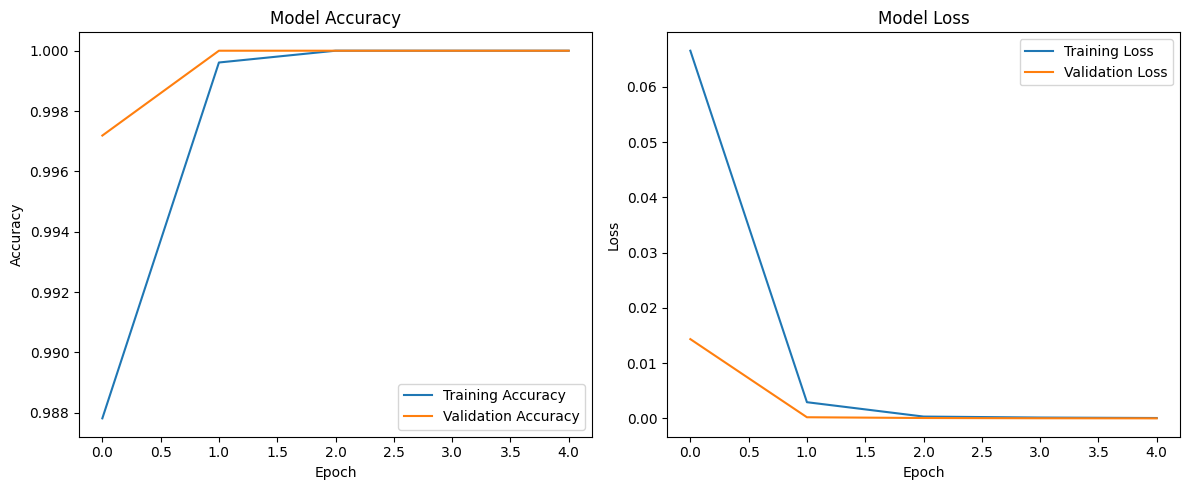

125/125 [==============================] - 15s 105ms/step - loss: 2.3719e-05 - binary_accuracy: 1.0000 - auc_1: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000
Test AUC: 1.0000
125/125 [==============================] - 15s 111ms/step


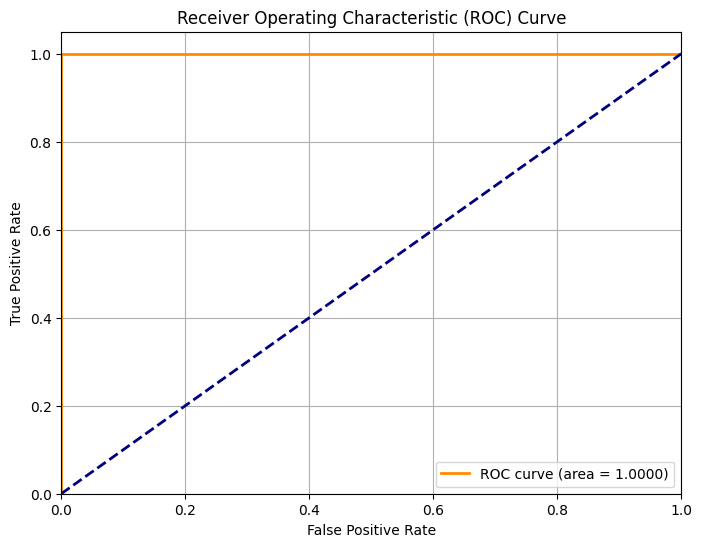

Accuracy with threshold 0.5: 1.0000


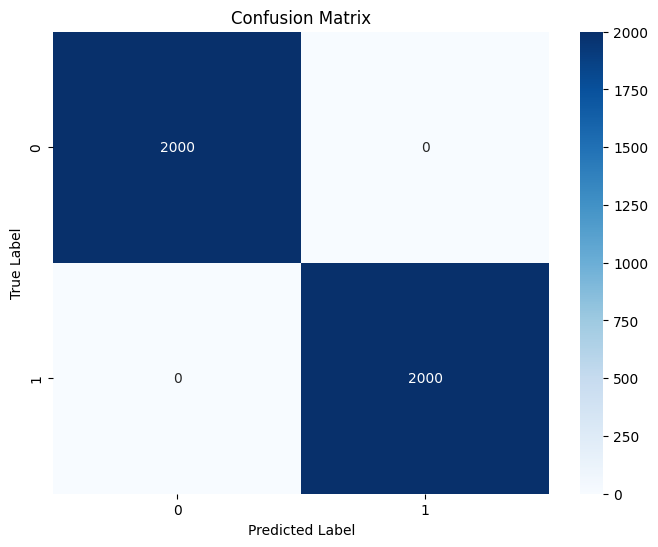

In [13]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = vit_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate predictions for ROC curve
y_pred_prob = vit_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Convert probabilities to binary predictions using 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with threshold 0.5: {accuracy:.4f}")

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# Save the model
vit_model.save('vit_hcal_classifier.h5')
print("Model saved to 'vit_hcal_classifier.h5'")

# Save the model architecture and weights separately if needed
vit_model.save_weights('vit_hcal_weights.h5')
with open('vit_hcal_architecture.json', 'w') as f:
    f.write(vit_model.to_json())
print("Model architecture and weights saved separately")

Model saved to 'vit_hcal_classifier.h5'
Model architecture and weights saved separately


In [15]:
# Final report section
print("="*50)
print("Model Architecture and Hyperparameters:")
print("="*50)
print("- Used a Vision Transformer (ViT) architecture")
print("- Patch size: 8x8")
print("- Projection dimension: 64")
print("- Number of transformer layers: 4")
print("- Number of attention heads: 4")
print("- MLP units in transformer blocks: [128, 64]")
print("- MLP head units: [256, 128]")
print("- Dropout rate: 0.1")
print("- Learning rate: 0.0001 with ReduceLROnPlateau scheduler")

print("\n")
print("="*50)
print("Data Preprocessing Steps:")
print("="*50)
print("1. Loaded two datasets (shape: 10000, 64, 72)")
print("2. Reshaped data to include channel dimension (shape: samples, 64, 72, 1)")
print("3. Normalized data between 0 and 1")
print("4. Split data into 80% training and 20% testing")
print("5. Further split training data into 80% training and 20% validation")

print("\n")
print("="*50)
print("Model Performance:")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Model Architecture and Hyperparameters:
- Used a Vision Transformer (ViT) architecture
- Patch size: 8x8
- Projection dimension: 64
- Number of transformer layers: 4
- Number of attention heads: 4
- MLP units in transformer blocks: [128, 64]
- MLP head units: [256, 128]
- Dropout rate: 0.1
- Learning rate: 0.0001 with ReduceLROnPlateau scheduler


Data Preprocessing Steps:
1. Loaded two datasets (shape: 10000, 64, 72)
2. Reshaped data to include channel dimension (shape: samples, 64, 72, 1)
3. Normalized data between 0 and 1
4. Split data into 80% training and 20% testing
5. Further split training data into 80% training and 20% validation


Model Performance:
Test Accuracy: 1.0000
Test AUC: 1.0000
ROC AUC: 1.0000
